# Forest Fire Detection


**Content**

Data was collected to train a model to distinguish between the images that contain fire (fire images) and regular images (non-fire images), so the whole problem was binary classification.



## Acquiring data and building datasets.

Data was acquired from kaggle: The dataset was created by a team during the NASA Space Apps Challenge in 2018, the goal was using the dataset to develop a model that can recognize the images with fire.

Data is divided into 2 folders, fire_images folder contains 755 outdoor-fire images some of them contains heavy smoke, the other one is non-fire_images which contain 244 nature images (eg: forest, tree, grass, river, people, foggy forest, lake, animal, road, and waterfall).

In [1]:
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

## Pre-processing and Exploratory Data Analysis

In [2]:
#create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/fire_dataset/fire_images'):
    for filename in filenames:

        new_data = pd.DataFrame([[os.path.join(dirname, filename), 'fire']], columns=['path', 'label'])
        df = pd.concat([df, new_data], ignore_index=True)

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/fire_dataset/non_fire_images'):
    for filename in filenames:

        new_data = pd.DataFrame([[os.path.join(dirname, filename), 'non_fire']], columns=['path', 'label'])
        df = pd.concat([df, new_data], ignore_index=True)


df.head(10)


path label
0  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
1  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
2  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
3  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
4  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
5  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
6  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
7  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
8  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire
9  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire

In [3]:
# Scatterplot to show the distribution of fire and non-fire images along the length of the dataframe.

fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

#### 🔀 Shuffle the data to introduce randomness which avoids order bias and leads to improved generalization when we train the model.

In [4]:
# shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)

df.head(10)

path     label
0  /content/drive/MyDrive/Dataset/fire_dataset/fi...      fire
1  /content/drive/MyDrive/Dataset/fire_dataset/fi...      fire
2  /content/drive/MyDrive/Dataset/fire_dataset/fi...      fire
3  /content/drive/MyDrive/Dataset/fire_dataset/fi...      fire
4  /content/drive/MyDrive/Dataset/fire_dataset/fi...      fire
5  /content/drive/MyDrive/Dataset/fire_dataset/no...  non_fire
6  /content/drive/MyDrive/Dataset/fire_dataset/fi...      fire
7  /content/drive/MyDrive/Dataset/fire_dataset/fi...      fire
8  /content/drive/MyDrive/Dataset/fire_dataset/no...  non_fire
9  /content/drive/MyDrive/Dataset/fire_dataset/fi...      fire

In [5]:
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

The above scatter plot proves that the shuffling of data is successful. Fire and non-fire images have evenly been distributed along the length of the dataframe.

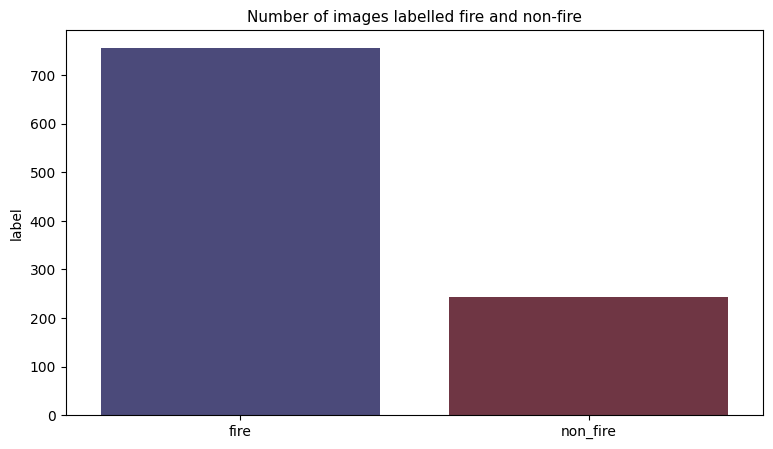

In [6]:
#Visualizing the data using a barchart

vc = df['label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc, palette = "icefire")
plt.title("Number of images labelled fire and non-fire", fontsize = 11)
plt.show()

Non fire label has less number of images.

#### Visualizing Fire images

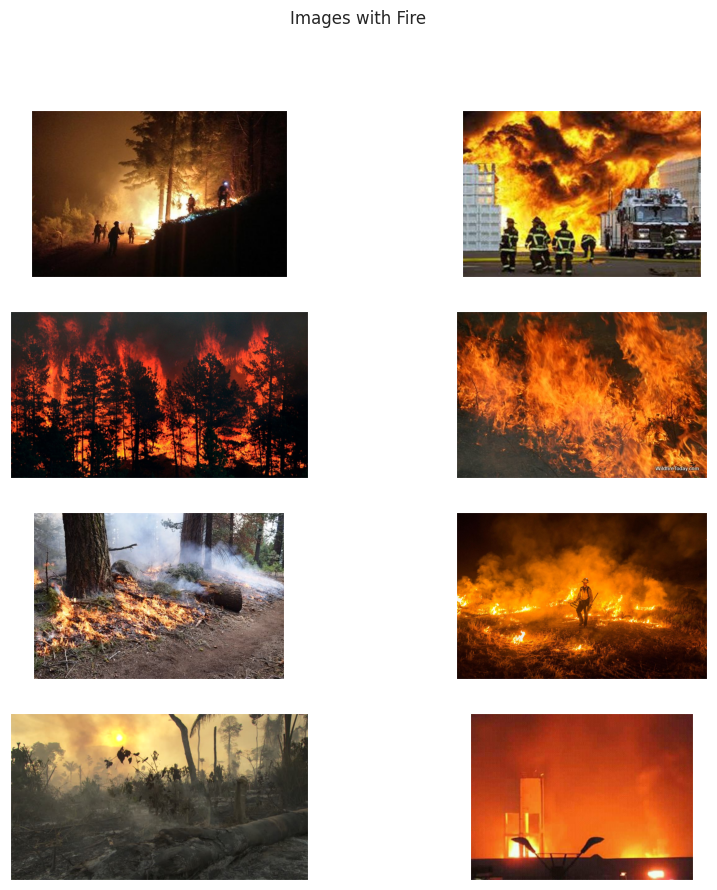

In [7]:
#label for images with fire
label = 'fire'
data = df[df['label'] == label]
sns.set_style('dark')


pics = 8 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(10,10))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

#### Visualizing non-fire images

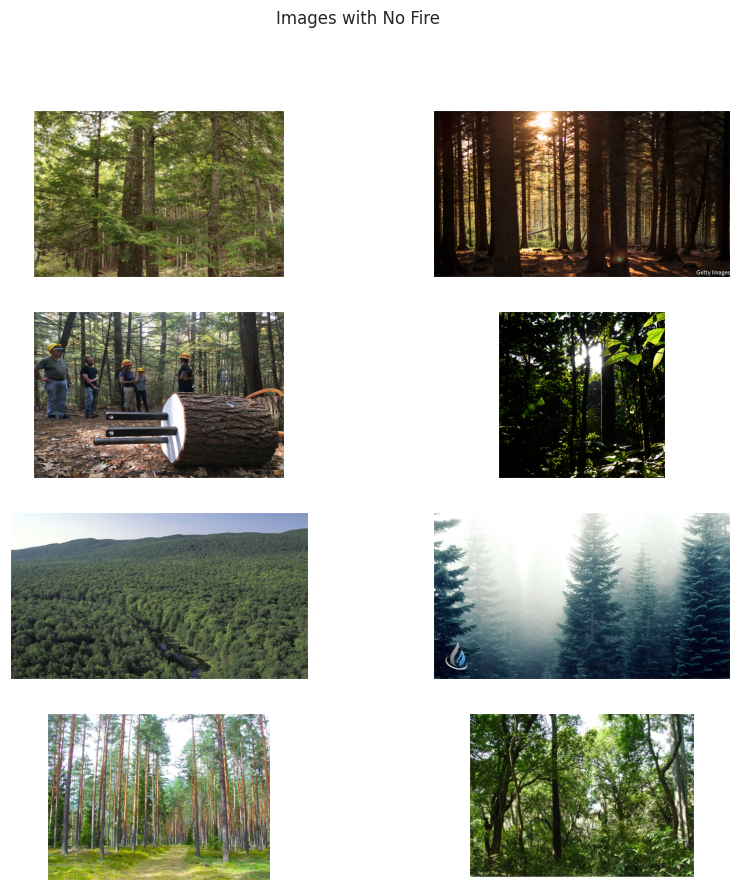

In [8]:
#label for images without fire
label = 'non_fire'
data = df[df['label'] == label]
sns.set_style('dark')

#set the number of pics
pics = 8
fig,ax = plt.subplots(int(pics//2),2,figsize=(10,10))
plt.suptitle('Images with No Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

Assessing the fire and non-fire images, it is evident that the images do not have a uniform size.

#### Visualize distribution of height and width of the images

In [9]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

path label  height  width
0  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire     385    685
1  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire     480    852
2  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire     338    450
3  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire     470    940
4  /content/drive/MyDrive/Dataset/fire_dataset/fi...  fire     360    640

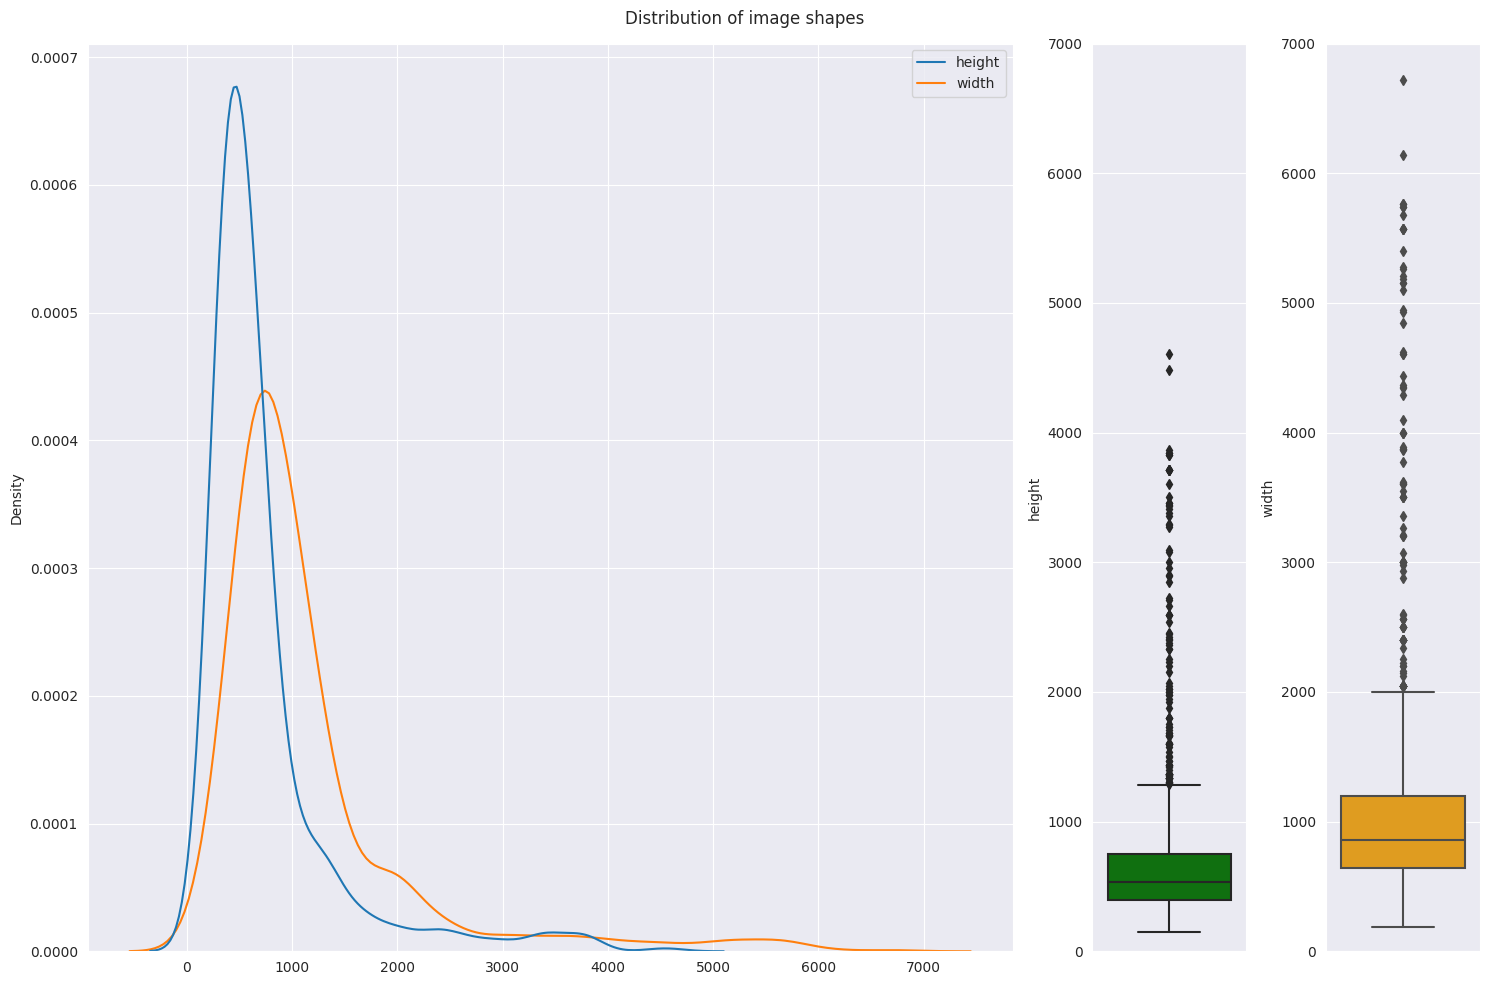

In [10]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='green')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

## Image Augmentation and Preprocessing

Performing scaling, data transformation and normalization of the images.

In [11]:
generator = ImageDataGenerator(
    # Randomly rotates the images by a specified angle in the range [-30, 30] degrees
    rotation_range= 30,
    # Randomly shifts the images horizontally by a fraction of the total width, with the fraction specified as 0.1
    width_shift_range=0.1,
    # Randomly shifts the images vertically by a fraction of the total height, with the fraction specified as 0.1
    height_shift_range=0.1,
    # Applies shear transformations to the images
    shear_range = 0.3,
    # Randomly zooms into the images by a factor in the range [1-0.2, 1+0.2]
    zoom_range=0.2,
    # Normalization, specifically min-max scaling. This rescales the pixel values of the images to be in the range [0, 1].
    rescale = 1/255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
    # Specifies the fraction of the data to be used for validation. In this case, 20% of the data will be reserved
    validation_split=0.2,

    #featurewise_center=True,
    # Standarization
    #featurewise_std_normalization=True,
)

Using `flow_from_dataframe` method of the ImageDataGenerator to generate batches of augmented image data from a Pandas DataFrame.

In [12]:
train_gen = generator.flow_from_dataframe(
    df,
    x_col='path',
    y_col='label',
    images_size=(256,256),
    class_mode='binary',
    subset='training')

val_gen = generator.flow_from_dataframe(
    df,
    x_col='path',
    y_col='label',
    images_size=(256,256),
    class_mode='binary',
    subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


In [13]:
# Checking the class indices for the labels

class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key

print(class_indices)

{0: 'fire', 1: 'non_fire'}


Prediction of 0 means 'Fire' and 1 means 'No Fire'

#### Visualizing how Generator Applied Images Look Like

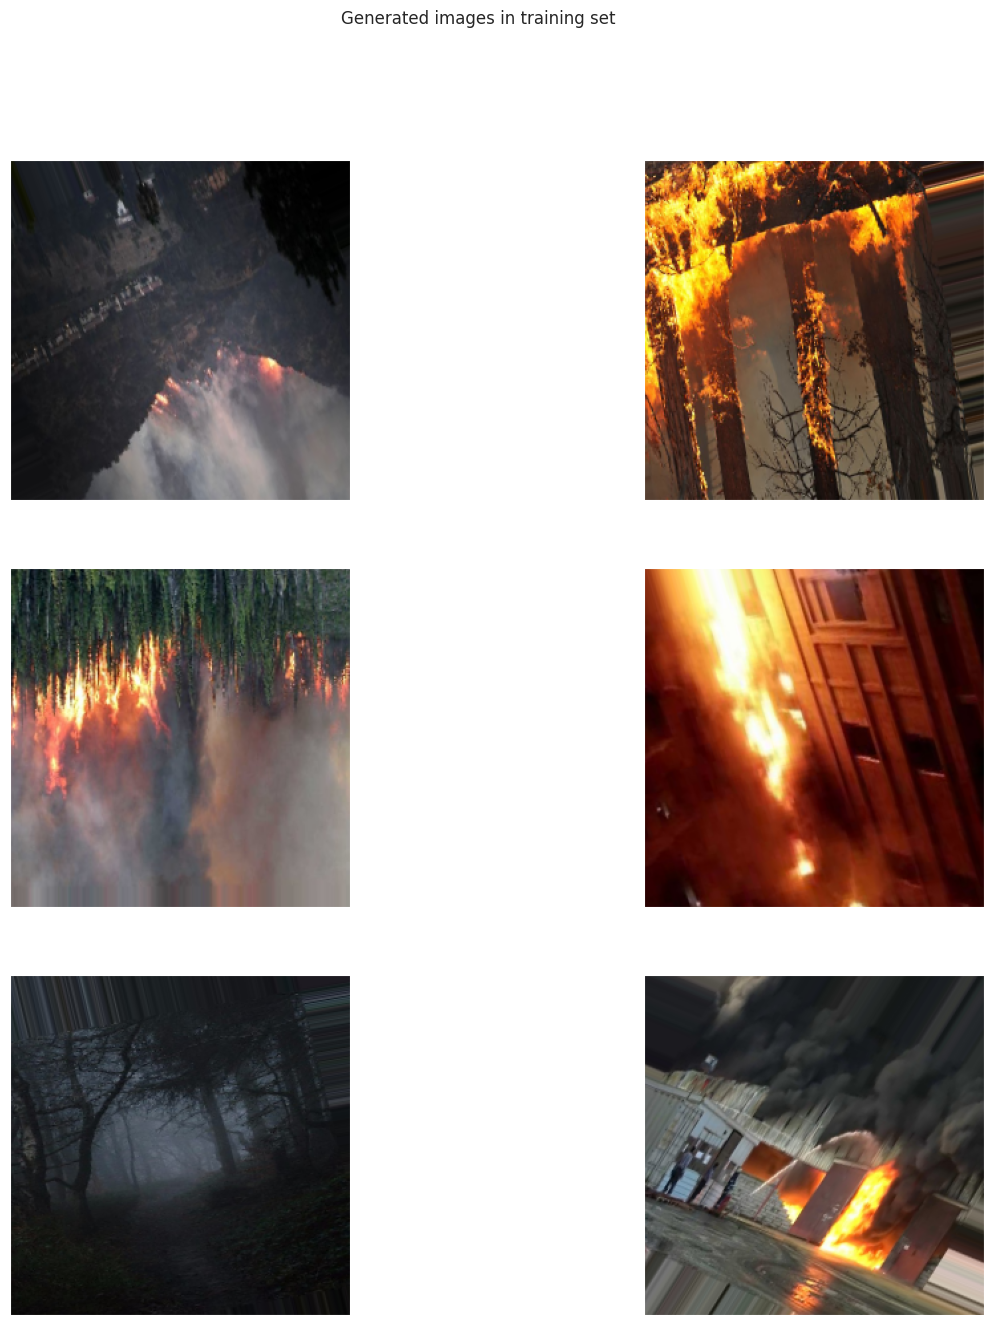

In [14]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

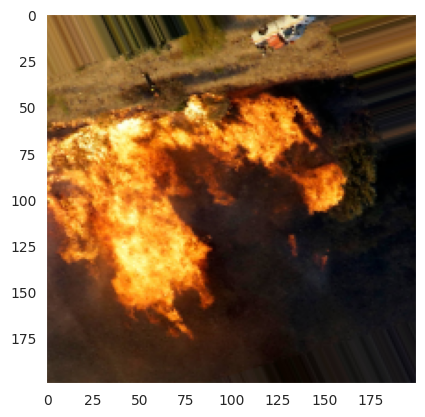

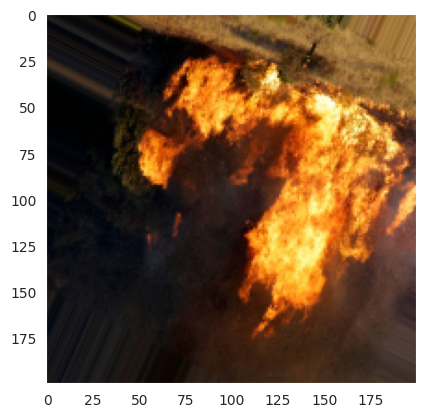

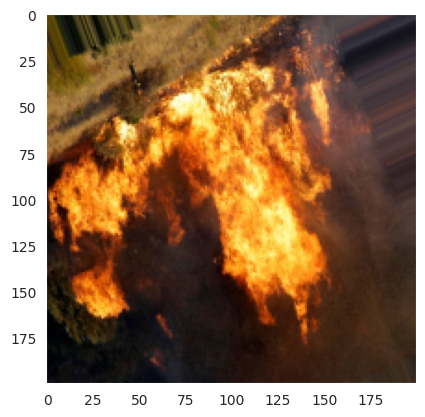

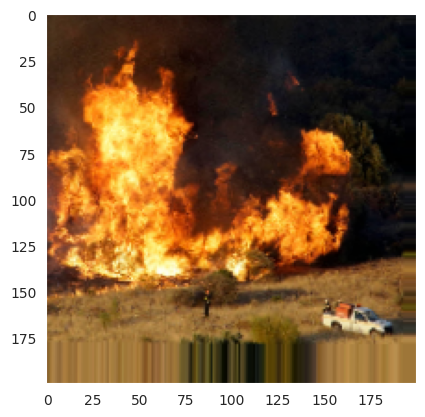

In [15]:
example_Image = df["path"][99]
Load_Image = image.load_img(example_Image,target_size=(200,200))
Array_Image = image.img_to_array(Load_Image)
Array_Image = Array_Image.reshape((1,) + Array_Image.shape)

i = 0
for batch in generator.flow(Array_Image,batch_size=1):
    plt.figure(i)
    IMG = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

## Creating the Base Model

In [16]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 128)       0

In [18]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [19]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

In [20]:
model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/15
25/25 [==============================] - 50s 1s/step - loss: 0.3559 - accuracy: 0.8562 - recall: 0.5208 - auc: 0.8828 - val_loss: 0.1805 - val_accuracy: 0.9045 - val_recall: 0.9423 - val_auc: 0.9834 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 35s 1s/step - loss: 0.1585 - accuracy: 0.9413 - recall: 0.8490 - auc: 0.9762 - val_loss: 0.2067 - val_accuracy: 0.8995 - val_recall: 0.9615 - val_auc: 0.9846 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 41s 2s/step - loss: 0.1430 - accuracy: 0.9400 - recall: 0.8490 - auc: 0.9803 - val_loss: 0.1317 - val_accuracy: 0.9347 - val_recall: 0.7885 - val_auc: 0.9905 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 36s 1s/step - loss: 0.1170 - accuracy: 0.9538 - recall: 0.8698 - auc: 0.9881 - val_loss: 0.1831 - val_accuracy: 0.9196 - val_recall: 0.9423 - val_auc: 0.9866 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 35s 1s/step - loss: 0.1366 - accuracy: 0.9438 - recall: 

In [21]:
history= model.history.history
px.line(history,title = "Metrics Plot")

Plotting Metrics

In [22]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 8s 1s/step - loss: 0.0891 - accuracy: 0.9698 - recall: 0.9231 - auc: 0.9935
loss: 0.09
accuracy: 0.97
recall: 0.92
auc: 0.99


## Optimizing the base model: Hyperparameter Tuning

In [23]:
model1 = Sequential()
model1.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (256,256,3)))
model1.add(MaxPool2D())
model1.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model1.add(MaxPool2D())
model1.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model1.add(MaxPool2D())
model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
# model.add(Dropout(0.5))
model1.add(Dense(32,activation = 'relu'))
model1.add(Dense(1,activation = 'sigmoid'))

In [24]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 128)       32896     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 31, 31, 128)      

In [25]:
model1.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [26]:
model1.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/15
25/25 [==============================] - 38s 1s/step - loss: 0.4867 - accuracy: 0.7775 - recall_1: 0.4479 - auc_1: 0.7934 - val_loss: 0.2022 - val_accuracy: 0.9296 - val_recall_1: 0.9038 - val_auc_1: 0.9763 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 38s 2s/step - loss: 0.2462 - accuracy: 0.8963 - recall_1: 0.7344 - auc_1: 0.9502 - val_loss: 0.1463 - val_accuracy: 0.9447 - val_recall_1: 0.9615 - val_auc_1: 0.9954 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 38s 1s/step - loss: 0.1766 - accuracy: 0.9425 - recall_1: 0.8542 - auc_1: 0.9700 - val_loss: 0.3899 - val_accuracy: 0.8090 - val_recall_1: 0.2692 - val_auc_1: 0.9774 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 35s 1s/step - loss: 0.1405 - accuracy: 0.9500 - recall_1: 0.8333 - auc_1: 0.9809 - val_loss: 0.0802 - val_accuracy: 0.9648 - val_recall_1: 0.9423 - val_auc_1: 0.9960 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 35s 1s/step - loss: 0.17

In [27]:
eval_list = model1.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 8s 1s/step - loss: 0.0638 - accuracy: 0.9749 - recall_1: 0.9615 - auc_1: 0.9983
loss: 0.06
accuracy: 0.97
recall_1: 0.96
auc_1: 1.00


### By doing hyperparameter tuning, we infer that for this case, the 'rmsprop' optimizer provides more optimal metrics compared to the 'adam' optimizer we used in the base model

## Model Training with Transfer Learning

In [28]:
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

83683744/83683744 [==============================] - 3s 0us/step


In [29]:
model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

In [30]:
history2 = model2.fit(x = train_gen,batch_size=32,epochs=15,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/15
25/25 [==============================] - 45s 2s/step - loss: 0.9830 - accuracy: 0.9050 - recall_2: 0.7812 - auc_2: 0.9074 - val_loss: 0.3340 - val_accuracy: 0.9397 - val_recall_2: 0.9038 - val_auc_2: 0.9670 - lr: 0.0010
Epoch 2/15
25/25 [==============================] - 37s 1s/step - loss: 0.2274 - accuracy: 0.9563 - recall_2: 0.9167 - auc_2: 0.9759 - val_loss: 0.3148 - val_accuracy: 0.9146 - val_recall_2: 0.9038 - val_auc_2: 0.9753 - lr: 0.0010
Epoch 3/15
25/25 [==============================] - 37s 1s/step - loss: 0.1863 - accuracy: 0.9625 - recall_2: 0.9062 - auc_2: 0.9737 - val_loss: 0.2496 - val_accuracy: 0.9347 - val_recall_2: 0.9038 - val_auc_2: 0.9791 - lr: 0.0010
Epoch 4/15
25/25 [==============================] - 38s 2s/step - loss: 0.1738 - accuracy: 0.9538 - recall_2: 0.9010 - auc_2: 0.9813 - val_loss: 0.1826 - val_accuracy: 0.9397 - val_recall_2: 0.7692 - val_auc_2: 0.9840 - lr: 0.0010
Epoch 5/15
25/25 [==============================] - 37s 2s/step - loss: 0.11

In [31]:
px.line(history,title='Metrics Plot')

In [32]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 [==============================] - 8s 1s/step - loss: 0.0824 - accuracy: 0.9799 - recall: 0.9808 - auc: 0.9959
loss: 0.08
accuracy: 0.98
recall: 0.98
auc: 1.00


### We are able to improve the metrics by leveraging a pre-trained model, such as Xception, which results in even better metrics, in this case: 98% accuracy and a loss of 0.08

## Testing The Model

In [33]:
#Downloading the image
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50241  100 50241    0     0   217k      0 --:--:-- --:--:-- --:--:--  218k


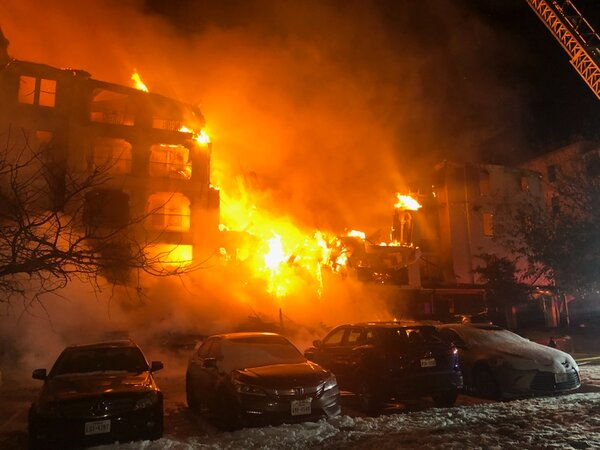

In [34]:
#loading the image
img = image.load_img('predict.jpg')
img

In [35]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


In [36]:
prediction = int(tf.round(model2.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 [==============================] - 1s 1s/step
The predicted value is:  0 and the predicted label is: fire


## Saving the Model

In [37]:
model.save('/content/drive/MyDrive/Dataset/FireDetection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [38]:
from google.colab import files
import pickle

file_path = '/content/drive/MyDrive/Dataset/FireDetection_model.pkl'

with open(file_path, 'wb') as f:
    pickle.dump(model2, f)
